# 2024 Harris vs. Trump Election Prediction
The practice followed [ritvikmath](https://www.youtube.com/watch?v=O5-A2ensKb0) guidance on utilizing Bayesian methodology, using 2020 election data (`prior`), with current polling data of 7 swing states (`likelihood`) to get 2024 election prediction (`posterior`). A baseline level of uncertainty is allowed for the prediction, which usually becomes lower as we get clower to the date of election.

In [ ]:
!pip install numpy pandas matplotlib seaborn requests bs4

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 40.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 41.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 39.2 MB/s eta 0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [69]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 21.6 MB/s eta 0:00:00a 0:00:01


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import urllib3 # to bypass SSL verification and suppress warnings (not recommended for production level)
import os 
import scipy.stats as stats
print(os.getcwd()) #print the current working directory

/Users/linlin/Documents/DS_sideProjects/statisticalAnalysis


In [2]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None) #None as no column limit for display

In [3]:
cwd = os.getcwd()
relative_path = "votingState.txt"
file_path = os.path.join(cwd, relative_path)

In [4]:
with open(file_path, 'r') as file:
    text = file.read()
    print(text[:100])


Alabama - 9 votes

Kentucky - 8 votes

North Dakota - 3 votes

Alaska - 3 votes

Louisiana - 8 votes


In [5]:
# Regex pattern to find state name
pattern = r"^[A-Za-z\s]+(?=\s*-\s*\d+\s*votes\n)"
voting_states = re.findall(pattern, text, flags=re.M)
voting_states = [match.strip() for match in voting_states]
print(voting_states)

['Alabama', 'Kentucky', 'North Dakota', 'Alaska', 'Louisiana', 'Ohio', 'Arizona', 'Maine', 'Oklahoma', 'Arkansas', 'Maryland', 'Oregon', 'California', 'Massachusetts', 'Pennsylvania', 'Colorado', 'Michigan', 'Rhode Island', 'Connecticut', 'Minnesota', 'South Carolina', 'Delaware', 'Mississippi', 'South Dakota', 'District of Columbia', 'Missouri', 'Tennessee', 'Florida', 'Montana', 'Texas', 'Georgia', 'Nebraska', 'Utah', 'Hawaii', 'Nevada', 'Vermont', 'Idaho', 'New Hampshire', 'Virginia', 'Illinois', 'New Jersey', 'Washington', 'Indiana', 'New Mexico', 'West Virginia', 'Iowa', 'New York', 'Wisconsin', 'Kansas', 'North Carolina']


* `^` anchor the start of each line
* `re.M` allows `^` to work on each line independently
* `str.strip()` to remove any leading or trailing whitespace
*`\s` match any whitespace character

## Read 2020 Election Data

In [6]:
cwd = os.getcwd()
relative_path = "2020_election_results.txt"
file_path = os.path.join(cwd, relative_path)

In [7]:
# read 2020 election result text file and extract 
try:
    with open(file_path, 'r') as file:
        text = file.read()
    print(text[:200]) # display the first 100 characters to confirm success
except FileNotFoundError:
    print(f"File not found at {file_path}")
except UnicodeDecodeError:
    print(f"Encoding issue while reading the file. Try another eoncding.")


STATE RESULTS
President: Alabama
9 Electoral Votes
Trump
PROJECTED WINNER
+ FOLLOW
Candidate	%		Votes
Trump
62.0%	
1,441,170
Biden
36.6%	
849,624
Est. 99% In
Updated 10:17 p.m. ET, Mar. 6
Full Details


[`regex`](https://www.w3schools.com/python/python_regex.asp) to extract expression pattern, and comfile the matches into dataframe:

In [8]:
pattern = (
    # Lines begin with 'President', followed by the state name into 'state' column
    r"President:\s*(?P<state>[A-Za-z\s]+)\n"
    r"(?P<electoral_votes>\d+)\s*Electoral Votes\n"
    r"(?P<winner>Trump|Biden)\nPROJECTED WINNER\n\+ FOLLOW\n"
    # Tie votes to name
    r"Candidate\t%\t\tVotes\n(?P<candidate1>Trump|Biden)\n(?:\d+\.\d+%)?\s*\n?(?P<votes1>[\d,]+)\n(?P<candidate2>Trump|Biden)\n(?:\d+.\d+%)?s*\n?(?P<votes2>[\d,]+)"
)

In [9]:
# Compile the regrex pattern
regex = re.compile(pattern)

# Find all matches in the text and return a list of tuples
# matches = regex.findall(text)
matches = regex.finditer(text)

In [ ]:
# matches

[('Alabama', '9', 'Trump', 'Trump', '1,441,170', 'Biden', '36'), ('Alaska', '3', 'Trump', 'Trump', '189,951', 'Biden', '42'), ('Arizona\nParty change\nBATTLEGROUND', '11', 'Biden', 'Biden', '1,672,143', 'Trump', '49'), ('Arkansas', '6', 'Trump', 'Trump', '760,647', 'Biden', '34'), ('California', '55', 'Biden', 'Biden', '11,110,250', 'Trump', '34'), ('Colorado\nBATTLEGROUND', '9', 'Biden', 'Biden', '1,804,352', 'Trump', '41'), ('Connecticut', '7', 'Biden', 'Biden', '1,080,831', 'Trump', '39'), ('Delaware', '3', 'Biden', 'Biden', '296,268', 'Trump', '39'), ('District Of Columbia', '3', 'Biden', 'Biden', '317,323', 'Trump', '5'), ('Florida\nBATTLEGROUND', '29', 'Trump', 'Trump', '5,668,731', 'Biden', '47'), ('Georgia\nParty change\nBATTLEGROUND', '16', 'Biden', 'Biden', '2,473,633', 'Trump', '49'), ('Hawaii', '4', 'Biden', 'Biden', '366,130', 'Trump', '34'), ('Idaho', '4', 'Trump', 'Trump', '554,119', 'Biden', '33'), ('Illinois', '20', 'Biden', 'Biden', '3,471,915', 'Trump', '40'), ('Indi

`matches` is a list of tuples, if using `re.findall()`, can only access with index such as `match[0]`. Or use `re.finditer()` to return match objects (so that you could use `.group()` later)

In [10]:
# Process the matches
results = []
for match in matches:
    candidate1 = match.group('candidate1')
    votes1 = int(match.group('votes1').replace(',',''))
    candidate2 = match.group('candidate2')
    votes2 = int(match.group('votes2').replace(',',''))  

    # Assign votes to candidates
    if candidate1 == 'Trump':
        trump_votes, biden_votes = votes1, votes2
    else:
        trump_votes, biden_votes = votes2, votes1
    
    # Append the results
    results.append({
        "State": match.group('state'), #instead of match[0] so that we prevent indexing error
        # winner takes all
        "Electoral Votes": int(match.group('electoral_votes')),
        "Winner": match.group('winner'),
        "Trump Votes": trump_votes,
        "Biden Votes": biden_votes
    })

voting_df = pd.DataFrame(results)


In [19]:
voting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   State            49 non-null     object
 1   Electoral Votes  49 non-null     int64 
 2   Winner           49 non-null     object
 3   Trump Votes      49 non-null     int64 
 4   Biden Votes      49 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [11]:
# Winner takes all
voting_df['Trump Electoral Votes'] = voting_df.apply(lambda row: row['Electoral Votes'] if row.Winner == 'Trump' else 0, 1) 
voting_df['Biden Electoral Votes'] = voting_df.apply(lambda row: row['Electoral Votes'] if row.Winner == 'Biden' else 0, 1)

In [21]:
voting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   State                  49 non-null     object
 1   Electoral Votes        49 non-null     int64 
 2   Winner                 49 non-null     object
 3   Trump Votes            49 non-null     int64 
 4   Biden Votes            49 non-null     int64 
 5   Trump Electoral Votes  49 non-null     int64 
 6   Biden Electoral Votes  49 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.8+ KB


In [22]:
voting_df.head()

,State,Electoral Votes,Winner,Trump Votes,Biden Votes,Trump Electoral Votes,Biden Electoral Votes
0,Alabama,9,Trump,1441170,36,9,0
1,Alaska,3,Trump,189951,42,3,0
2,Arizona\nParty change\nBATTLEGROUND,11,Biden,49,1672143,0,11
3,Arkansas,6,Trump,760647,34,6,0
4,California,55,Biden,34,11110250,0,55


From above we see that State column requires cleansing: 
-> split on newline character(`\n`) and takes only the first index

In [12]:
voting_df.State = voting_df.State.apply(lambda x: x.split('\n')[0]) 

Check if there's missing data: 
* `set()` are optimized for operations like `difference` or `intersection`, faster than comparing 2 lists directly, and it automatically removes duplicates

In [13]:
present_states = set(voting_df.State)
missing_states = set(voting_states) - present_states
print(missing_states)

{'Nebraska', 'District of Columbia', 'Maine'}


In [25]:
voting_df.State.unique

<bound method Series.unique of 0                  Alabama
1                   Alaska
2                  Arizona
3                 Arkansas
4               California
5                 Colorado
6              Connecticut
7                 Delaware
8     District Of Columbia
9                  Florida
10                 Georgia
11                  Hawaii
12                   Idaho
13                Illinois
14                 Indiana
15                    Iowa
16                  Kansas
17                Kentucky
18               Louisiana
19                Maryland
20           Massachusetts
21                Michigan
22               Minnesota
23             Mississippi
24                Missouri
25                 Montana
26                  Nevada
27           New Hampshire
28              New Jersey
29              New Mexico
30                New York
31          North Carolina
32            North Dakota
33                    Ohio
34                Oklahoma
35                  Oreg

We have `District Of Columbia`, but indeed missing the other two.

`voting_df['State']` is a pandas Series, so we use `isin()`

In [14]:
na_df = voting_df[voting_df['State'].isin(missing_states)] 
print(na_df)

Empty DataFrame
Columns: [State, Electoral Votes, Winner, Trump Votes, Biden Votes, Trump Electoral Votes, Biden Electoral Votes]
Index: []


In [15]:
dc_rows = voting_df[voting_df['State'] == 'District Of Columbia']
print("Rows with District of Columbia:")
print(dc_rows)


Rows with District of Columbia:
                  State  Electoral Votes Winner  Trump Votes  Biden Votes  \
8  District Of Columbia                3  Biden            5       317323   

   Trump Electoral Votes  Biden Electoral Votes  
8                      0                      3  


Confirmed that it's font size issue.

In [16]:
# Add missing data
missing_df = pd.DataFrame(
    columns=voting_df.columns,
    data=[['Maine', 4, 'Biden', 360737, 435072, 1, 3], ['Nebraska', 5, 'Trump', 556846, 374583, 4, 1]]
)

voting_df = pd.concat([voting_df, missing_df])

voting_df = voting_df.sort_values('State').reset_index(drop=True)

In [28]:
voting_df.head()

,State,Electoral Votes,Winner,Trump Votes,Biden Votes,Trump Electoral Votes,Biden Electoral Votes
0,Alabama,9,Trump,1441170,36,9,0
1,Alaska,3,Trump,189951,42,3,0
2,Arizona,11,Biden,49,1672143,0,11
3,Arkansas,6,Trump,760647,34,6,0
4,California,55,Biden,34,11110250,0,55


## Scrape latest state-level polling data

Source: [538 Polls data](https://projects.fivethirtyeight.com/polls/president-general)

In [17]:
# Suppress warnings if SSL verification is disabled
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Core Scraper
* Extract poll data from the correct table rows (`<tr>`)
* Handle structure variation (eg. missing poll results, different candidate names)
* Store daata in a structured dictionary for a easy conversion to dataframe
---
* `fina_all()` returns multiple elements, but as we need only one, could use `find()` instead to search for a single element.
* `str.contains()` to return matches like "Biden", "Harris".
* If data is misssing, fill with nataional data.
* Since the percentage is inside a `<div>`, we need to access the `<div>` first.
* Ensure we always use "Harris" as it could be `array(['Kennedy', 'Harris', 'Biden'], dtype=object)`

Found Trump's polling result as this for those having "More" toggle:
```
<tr class="expandable-row">
...
   </div>
   <div class="value hide-mobile expandable">
    <div class="heat-map" style="background-color:#dc543f;color:#ffffff;">
     59%
    </div>
    <span class="choiceName">
     Trump
    </span>
   </div>
   <div class="value hide-mobile expandable">
```

In [42]:
# Fallback: national polling url
NATIONAL_url = "https://projects.fivethirtyeight.com/polls/president-general/2024/national/"

In [61]:
def get_latest_poll(url, state):
    response = requests.get(url, verify=False)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all rows for polls
    all_rows = soup.find_all('tr')
    latest_poll = next((row for row in all_rows if 'visible-row' in row.get('class', [])), None)

    if not latest_poll:
        print(f"No polling data found for state: {state}.")
        return None

    results_dict = {
        'State': state,
        'Date': None,
        'Sample Size': None,
        'Pollster': None,
        'Democratic Candidate': None,
        'Democratic Result': None,
        'Trump Result': None
    }

    # Extract basic information
    try:
        results_dict['Date'] = latest_poll.find('td', class_='dates hide-mobile').get_text(strip=True)
        results_dict['Sample Size'] = latest_poll.find('td', class_='sample hide-mobile').get_text(strip=True)
        results_dict['Pollster'] = latest_poll.find('div', class_='pollster-name').get_text(strip=True)

        # Extract Democratic candidate and result
        dem_candidate = latest_poll.find('td', class_='answer first hide-mobile').get_text(strip=True)
        dem_result = latest_poll.find('td', class_='value hide-mobile hide-default').get_text(strip=True)

        # Normalize Democratic Candidate to "Harris"
        if dem_candidate in ['Biden', 'Kennedy']:
            dem_candidate = 'Harris'
        results_dict['Democratic Candidate'] = dem_candidate
        results_dict['Democratic Result'] = dem_result
        
        # Extract Trump result from the main row
        trump_cell = latest_poll.find('td', class_='answer hide-mobile', string="Trump")
        if trump_cell:
            trump_result = trump_cell.find_previous_sibling('td', class_='value hide-mobile')
            if trump_result:
                results_dict['Trump Result'] = trump_result.get_text(strip=True)

        # If Trump is missing, check the expandable row
        if results_dict['Trump Result'] is None:
            expandable_row = latest_poll.find_next_sibling('tr', class_='expandable-row')
            if expandable_row:
                candidate_blocks = expandable_row.find_all('div', class_='value hide-mobile expandable')
                for block in candidate_blocks:
                    candidate_name = block.find('span', class_='choiceName')
                    if candidate_name and "Trump" in candidate_name.get_text(strip=True):
                        heat_map_div = block.find('div', class_='heat-map')
                        if heat_map_div:
                            results_dict['Trump Result'] = heat_map_div.get_text(strip=True)
                            break  # Stop once we find Trump's result

    except AttributeError as e:
        print(f"Error parsing data for {state}: {e}")
        return None

    return results_dict

In [62]:
# Example usage
state = "north-carolina"#"rhode-island"#"north-dakota"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'north-carolina', 'Date': 'Nov. 3-4, 2024', 'Sample Size': '1,219', 'Pollster': 'AtlasIntel', 'Democratic Candidate': 'Harris', 'Democratic Result': '48%', 'Trump Result': '50%'}


In [63]:
state = "rhode-island"#"north-dakota"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'rhode-island', 'Date': 'Oct.\xa029-Nov.\xa02, 2024', 'Sample Size': '708', 'Pollster': 'University of New Hampshire Survey Center', 'Democratic Candidate': 'Harris', 'Democratic Result': '54%', 'Trump Result': '40%'}


In [64]:
state = "north-dakota"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'north-dakota', 'Date': 'Sept. 28-30, 2024', 'Sample Size': '500', 'Pollster': 'WPA Intelligence', 'Democratic Candidate': 'Harris', 'Democratic Result': '32%', 'Trump Result': '59%'}


In [65]:
state = "alaska"
url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/{state}/"
latest_poll = get_latest_poll(url, state)
print(latest_poll)

{'State': 'alaska', 'Date': 'Oct. 20-22, 2024', 'Sample Size': '1,703', 'Pollster': 'Alaska Survey Research', 'Democratic Candidate': 'Harris', 'Democratic Result': '45%', 'Trump Result': '55%'}


### Intermediate Function
Dynamically builds the state URL and passes it to get_latest_poll

In [55]:
# Function to dynamically constructs the URL for a given state based on its abbreviation
def get_poll_url(state):
    """Construcst a URL for a given state's polling data by formatting its name
    """
    # Define the URL for DC because of error in http
    if state == "District of Columbia":#only has 2020 polling result
        state_url = f"https://projects.fivethirtyeight.com/polls/president-general/2020/"
    else:
        state_url = f"https://projects.fivethirtyeight.com/polls/president-general/2024/"

    # Convert spaces to hyphens 
    formatted_state = state.lower().replace(" ", "-")
    return f"{state_url}{formatted_state}/"

In [56]:
# Testing
voting_states_sample = ["North Carolina", "New Mexico", "District of Columbia"]
for state in voting_states_sample:
    print(get_poll_url(state))

https://projects.fivethirtyeight.com/polls/president-general/2024/north-carolina/
https://projects.fivethirtyeight.com/polls/president-general/2024/new-mexico/
https://projects.fivethirtyeight.com/polls/president-general/2020/district-of-columbia/


### Outer Loop (top level)

Iterate through the list of states and handle fallback logic with national polling dataif specific mathups (eg. Trump vs Harris) are unavailable

In [58]:
# Iterates through the list of states 
def collect_polling_data(voting_states):
    """Iterates through states and collects polling data with fallback to national polls
    """
    # Placeholder for all states' polling data
    all_poll_data = []

    for state in voting_states:
        # print(f"Fetching polling data for {state}...")
        
        # Construct URL dynamically
        state_url = get_poll_url(state)

        # Try fetching state polling data
        state_poll = get_latest_poll(state_url, state)
        
        # Fallback: If no state-level polls, fetch national polls
        if state_poll is None:
            # If no state-level polls, fetch national polling data
            print(f"No polling data for {state}. Falling back to national polls")
            national_url = NATIONAL_url
            state_poll = get_latest_poll(national_url, "National")

            # Assign state name to fallback national data
            if state_poll:
                state_poll['State'] = state
        
        # Store collected data
        if state_poll:
            all_poll_data.append(state_poll)         
    
    # Combine all states' data into a DataFrame
    if all_poll_data:
        polling_df = pd.DataFrame(all_poll_data)
        return polling_df
    else:
        print("No polling data collected.")
        return None

In [66]:
# Call the function
polling_df = collect_polling_data(voting_states)

# Display the combined polling data
if polling_df is not None:
    print(polling_df.head())
else:
    print("No data was collected.")

          State               Date Sample Size                Pollster  \
0       Alabama  April 13-21, 2024         513   John Zogby Strategies   
1      Kentucky  April 13-21, 2024         402   John Zogby Strategies   
2  North Dakota  Sept. 28-30, 2024         500        WPA Intelligence   
3        Alaska   Oct. 20-22, 2024       1,703  Alaska Survey Research   
4     Louisiana  April 22-26, 2024         800     Faucheux Strategies   

  Democratic Candidate Democratic Result Trump Result  
0               Harris               31%          56%  
1               Harris               35%          52%  
2               Harris               32%          59%  
3               Harris               45%          55%  
4               Harris               33%          48%  


In [79]:
polling_df.to_csv('polling_2024.csv', index=False)

In [67]:
polling_df["Democratic Candidate"].unique()

array(['Harris'], dtype=object)

## Simulate Election Outcomes Using Bayesian Statistics
* Prior: 2020 Election result
* Belief: Update with current polling data
* Baseline Uncertainty: 1%, 0.5% (normal distribution) to include randomness
* Baysian updating: $$P(win|polls)= (P(polls|win) * P(win)) / P(polls)$$
* Run 250 simulations for each state
* If Harris >= 270 electoral votes, wins.

1. Define weights & adjust votes:
* Use **Beta distribution `(Beta(alpha, beta))`** to model the probability of a state voting for Harris or Trump
    * alpha = weighted number of votes for Harris +1
    * beta = weighted number of votes for Trump +1
* **weights** to balance past election results and current polling data
    * $V_weighted = (V_2020 * weight_vote) + (V_poll * weight_poll)$
    * If no polling data exists, fall back to just `weight_vote`

2. Model probability with beta distribution:
* use the weighted votes to define the beta distribution: $$P_state ~ Beta(alpha, beta)$$

3. Run Monte Carlo simulations
run `Beta(alpha, beta).rvs()` multiple times

4. Aggregate electoral votes


In [80]:
polling_df.head()

,State,Date,Sample Size,Pollster,Democratic Candidate,Democratic Result,Trump Result
0,Alabama,"April 13-21, 2024",513,John Zogby Strategies,Harris,31%,56%
1,Kentucky,"April 13-21, 2024",402,John Zogby Strategies,Harris,35%,52%
2,North Dakota,"Sept. 28-30, 2024",500,WPA Intelligence,Harris,32%,59%
3,Alaska,"Oct. 20-22, 2024","1,703",Alaska Survey Research,Harris,45%,55%
4,Louisiana,"April 22-26, 2024",800,Faucheux Strategies,Harris,33%,48%


In [81]:
def simulate_election(voting_df, polling_df, weight_vote, weight_poll, baseline_uncertainty):
    """
    Simulates the 2024 election using a Bayesian approach with Beta distribution.

    Parameters:
    - voting_df: DataFrame with 2020 election results.
    - polling_df: DataFrame with latest polling data.
    - weight_vote: Weight assigned to 2020 election results.
    - weight_poll: Weight assigned to recent polling data.
    - baseline_uncertainty: The additional uncertainty factor per state.

    Returns:
    - A dictionary with simulation results.
    """
    harris_evotes = 0
    trump_evotes = 0

    for _, row in voting_df.iterrows():
        state = row['State']
        total_votes = row["Trump Votes"] + row["Biden Votes"]
        
        # Check if polling data exists for this state
        poll_row = polling_df[polling_df['State'] == state]
        
        if not poll_row.empty:
            # Use pollin data when available
            polling_harris = float(poll_row["Democratic Result"].values[0].strip('%'))/ 100
            polling_trump = float(poll_row["Trump Result"].values[0].strip('%'))/ 100
        else:
            # Fallback to 2020 results with increased uncertainty
            polling_harris = row['Biden Votes'] / total_votes
            polling_trump = row['Trump Votes'] / total_votes
        
        # Compute weighted probability
        if polling_harris is not None and polling_trump is not None:
            weighted_harris_votes = (polling_harris * weight_vote) + (weight_poll * polling_harris)
            weighted_trump_votes = (polling_trump * weight_vote) + (weight_poll * polling_trump)
        else:
            # No polling data, rely only on 2020 election results
            weighted_harris_votes = polling_harris
            weighted_trump_votes = polling_trump

        # Define Beta distribution parameters
        alpha_harris = weighted_harris_votes * total_votes + 1
        beta_harris = (1 - weighted_harris_votes) * total_votes + 1

        # Sample from beta distribution
        sample_harris_prob = stats.beta.rvs(alpha_harris, beta_harris)
        sample_trump_prob = 1 - sample_harris_prob #2-way race
        
        # Assign electorl votes based on sampled probability
        if sample_harris_prob > sample_trump_prob:
            harris_evotes += row["Electoral Votes"]
        else:
            trump_evotes += row["Electoral Votes"]
        
    return harris_evotes, trump_evotes



In [ ]:
# Set parameters
n_sim = 250 # number of simulations
baseline_uncertainty = 0.01

# Iterate over different choics of voting and polling weights
results = []

for weight_vote in np.arange(0.01, 1.01, 0.01):
    weight_vote = round(weight_vote, 10)
    weight_poll = round(1 - weight_vote, 10)
    
    # Run multiple sims for each weight level
    for _ in range(n_sim):
        harris_evotes, trump_evotes = simulate_election(voting_df, polling_df, weight_vote, weight_poll, baseline_uncertainty)
        results.append([weight_vote, weight_poll, harris_evotes, trump_evotes])
    

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['weight_vote', 'weight_poll', 'harris_evotes', 'trump_evotes'])

# Aggregate based on weight of polling data
stats_df = results_df.groupby('weight_poll').agg(
    avg_harris_evotes=pd.NamedAgg(column='harris_evotes', aggfunc=np.mean),
    std_harris_evotes=pd.NamedAgg(column='harris_evotes', aggfunc=np.std),
    avg_trump_evotes=pd.NamedAgg(column='trump_evotes', aggfunc=np.mean),
    std_trump_evotes=pd.NamedAgg(column='trump_evotes', aggfunc=np.std)
).reset_index()

print(stats_df.head())

   weight_poll  avg_harris_evotes  std_harris_evotes  avg_trump_evotes  \
0         0.00             206.42           2.503732            331.58   
1         0.01             206.64           2.501084            331.36   
2         0.02             206.78           2.489254            331.22   
3         0.03             206.44           2.504294            331.56   
4         0.04             206.60           2.503010            331.40   

   std_trump_evotes  
0          2.503732  
1          2.501084  
2          2.489254  
3          2.504294  
4          2.503010  


/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_6148/2151175141.py:21: FutureWarning: The provided callable <function mean at 0x108129b40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats_df = results_df.groupby('weight_poll').agg(
/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_6148/2151175141.py:21: FutureWarning: The provided callable <function std at 0x108129c60> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stats_df = results_df.groupby('weight_poll').agg(


In [85]:
def calculate_state_win_probs(voting_df, polling_df, weight_vote, weight_poll, baseline_uncertainty, num_simulations=10000):
    """Simulates state-by-state probabilities of winning."""
    
    state_results = []

    for _, row in voting_df.iterrows():
        state = row["State"]
        electoral_votes = row["Electoral Votes"]
        
        # Check if polling data exists for this state
        poll_row = polling_df[polling_df["State"] == state]

        if not poll_row.empty:
            # Use polling data when available
            polling_harris = float(poll_row["Democratic Result"].values[0].strip('%')) / 100
            polling_trump = float(poll_row["Trump Result"].values[0].strip('%')) / 100
        else:
            # Fallback to 2020 results with increased uncertainty
            polling_harris = row["Biden Votes"] / (row["Biden Votes"] + row["Trump Votes"])
            polling_trump = row["Trump Votes"] / (row["Biden Votes"] + row["Trump Votes"])

        # Compute weighted probability
        weighted_harris = (weight_vote * row["Biden Votes"] / (row["Biden Votes"] + row["Trump Votes"])) + (weight_poll * polling_harris)
        weighted_trump = (weight_vote * row["Trump Votes"] / (row["Biden Votes"] + row["Trump Votes"])) + (weight_poll * polling_trump)

        # Bayesian Beta Distribution
        alpha_harris = weighted_harris * (row["Biden Votes"] + row["Trump Votes"]) + 1
        beta_harris = (1 - weighted_harris) * (row["Biden Votes"] + row["Trump Votes"]) + 1

        # Simulate election multiple times
        harris_wins = 0
        for _ in range(num_simulations):
            sampled_harris_prob = stats.beta.rvs(alpha_harris, beta_harris)
            if sampled_harris_prob > 0.5:
                harris_wins += 1

        # Compute win probability
        harris_win_prob = harris_wins / num_simulations

        # Store result
        state_results.append({
            "State": state,
            "Harris Win %": harris_win_prob * 100,
            "Trump Win %": (1 - harris_win_prob) * 100
        })

    return pd.DataFrame(state_results)

# Run function
state_probabilities = calculate_state_win_probs(voting_df, polling_df, weight_vote=0.6, weight_poll=0.4, baseline_uncertainty=0.01)

# Display results
print(state_probabilities.head())


        State  Harris Win %  Trump Win %
0     Alabama           0.0        100.0
1      Alaska           0.0        100.0
2     Arizona         100.0          0.0
3    Arkansas           0.0        100.0
4  California         100.0          0.0


In [ ]:
!pip install geopandas descartes

In [89]:
!pip install wget

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9685 sha256=d669eb9390199e315db2617defc4c278417d00235cef4e845ca70597ec0a06d9
  Stored in directory: /Users/linlin/Library/Caches/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt
import wget

def plot_us_map(state_probabilities):
    """Plots a U.S. map showing win probabilities for each state."""

    # Load U.S. map
    wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")
    usa = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k.zip')

    # usa = gpd.read_file('data/usa-states-census-2014.shp')
    # usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    usa = usa[usa['iso_a3'] == 'USA']  # Filter for U.S.

    # Format state names
    state_probabilities["State"] = state_probabilities["State"].str.lower()

    # Merge state probabilities with map data
    usa = usa.merge(state_probabilities, left_on="name", right_on="State", how="left")

    # Create color-coded map
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    usa.plot(column='Harris Win %', cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax)

    # Formatting
    plt.title("State-by-State Harris Win Probability")
    plt.axis('off')

    plt.show()

# Call the function
plot_us_map(state_probabilities)


KeyError: 'iso_a3'

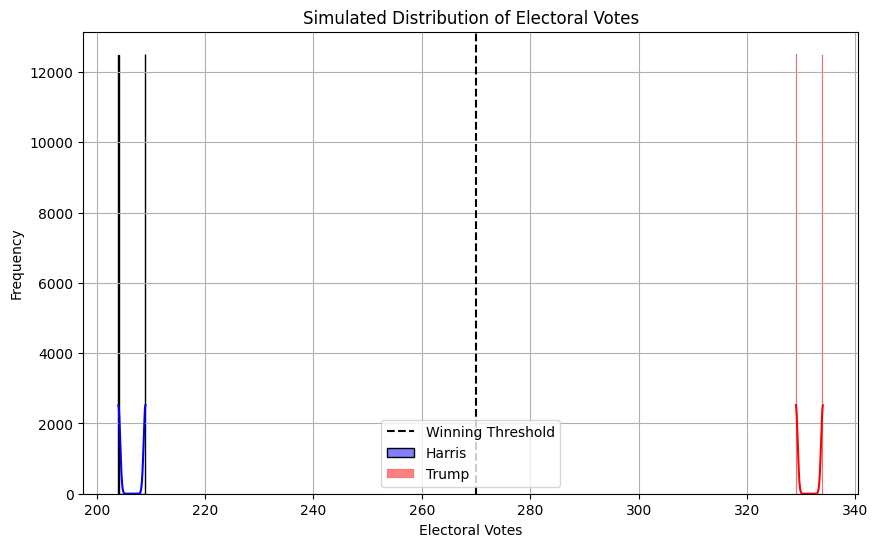

In [84]:
def plot_ev_histogram(results_df):
    """Plots a histogram of simulated Electoral Vote distributions."""
    plt.figure(figsize=(10, 6))

    # Histogram for Harris
    sns.histplot(results_df['harris_evotes'], bins=30, kde=True, color='blue', label='Harris')

    # Histogram for Trump
    sns.histplot(results_df['trump_evotes'], bins=30, kde=True, color='red', label='Trump')

    # Add vertical line at 270 EVs (Winning threshold)
    plt.axvline(270, color='black', linestyle='--', label='Winning Threshold')

    # Formatting
    plt.xlabel('Electoral Votes')
    plt.ylabel('Frequency')
    plt.title('Simulated Distribution of Electoral Votes')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function
plot_ev_histogram(results_df)


Pulling weighted average votes to the density of trust level to get the final predicted votes per candidates:

#### Different outputs per scenarios
| Baseline Uncertainty | Personal Polling Distribution | Harris | Trump |
| :------------------- | :---------------------------: | :----: | ----: |
| 1%                   | Centered at 0.7               | 270    | 268   |
| 0.5%                 | Centered at 0.7               | 259    | 279   |
| 1%                   | Centered at 0.1               | 284    | 254   |

